In [1]:
import sys
import os
sys.path.append("/cluster/home/vogtva/pde-data-gen")
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

## Determining the phase transition of the Brusselator

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates
import importlib
import plotly.express as px
import os
import glob
import pandas as pd
import json

import src.db_tools as db_tools
from src.db_tools import (
    get_dataset,
    expand_json_column,
    metrics_grid,
    plot_grid,
    compute_metrics,
    plot_all_trajectories
)

from classify import classify_trajectories

importlib.reload(db_tools);

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
model = "bruss"
ds_id = "pt_test"
ds, output_dir = get_dataset(model, ds_id)
df = ds.df
df = expand_json_column(df, "initial_condition", "ic", True)

df['ratio_b_a'] = df['B'] / df['A']
df['ratio_dv_du'] = df['Du'] / df['Dv']

In [5]:
def first_double_large_jump(arr: np.ndarray) -> int:
    diffs = np.diff(arr)
    large_jumps = diffs > 1 # More or less arbitray (unless it is too large)
    consecutive = np.where(large_jumps[:-1] & large_jumps[1:])[0]  # Find consecutive indices
    return consecutive[0] if consecutive.size > 0 else -1

In [6]:
df[(df.A == 4.75) & (df.B > 23)]

,run_id,model,A,B,Du,Dv,Nx,dx,Nt,dt,...,rel_std_u,rel_std_v,filename,idx,ic,ic_type,ic_sigma_u,ic_sigma_v,ratio_b_a,ratio_dv_du
1152,ecbaef95-178b-4df6-b00d-6cd25561e5f0,bruss,4.75,24.00000,2.0,22.0,128,1.0,60000,0.0025,...,0.000056,0.001731,/cluster/scratch/vogtva/data/bruss/phase_trans...,1152,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,5.052631,0.090909
1153,2a45d943-3a33-4d7b-972b-570f722b6e24,bruss,4.75,25.40625,2.0,22.0,128,1.0,60000,0.0025,...,NaN,NaN,/cluster/scratch/vogtva/data/bruss/phase_trans...,1153,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,5.348684,0.090909
1154,07aa2037-995a-4c1f-a7c4-a2f4efd37fe3,bruss,4.75,26.81250,2.0,22.0,128,1.0,60000,0.0025,...,NaN,NaN,/cluster/scratch/vogtva/data/bruss/phase_trans...,1154,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,5.644737,0.090909
1155,8c2d2ae1-c3cd-433f-8cb8-6faed4dd8f33,bruss,4.75,28.21875,2.0,22.0,128,1.0,60000,0.0025,...,NaN,NaN,/cluster/scratch/vogtva/data/bruss/phase_trans...,1155,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,5.940790,0.090909
1156,6b9c34d0-627a-4a6f-b563-774ba7acfe03,bruss,4.75,29.62500,2.0,22.0,128,1.0,60000,0.0025,...,NaN,NaN,/cluster/scratch/vogtva/data/bruss/phase_trans...,1156,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,6.236842,0.090909
1157,4e6f43de-7f5b-4239-bbaa-fe98715dbfbe,bruss,4.75,31.03125,2.0,22.0,128,1.0,60000,0.0025,...,NaN,NaN,/cluster/scratch/vogtva/data/bruss/phase_trans...,1157,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,6.532895,0.090909
1158,bb7858c5-fa4d-411b-b4f2-0d00b001e810,bruss,4.75,32.43750,2.0,22.0,128,1.0,60000,0.0025,...,NaN,NaN,/cluster/scratch/vogtva/data/bruss/phase_trans...,1158,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,6.828948,0.090909
1159,64b362de-46cc-494a-9b60-07d3b63282ec,bruss,4.75,33.84375,2.0,22.0,128,1.0,60000,0.0025,...,NaN,NaN,/cluster/scratch/vogtva/data/bruss/phase_trans...,1159,"{'sigma_u': 0.1, 'sigma_v': 0.1}",None,0.1,0.1,7.125000,0.090909


In [16]:
df[df.A == 0.8]["mean_dt"].sort_values()

19         0.000000
120        0.000000
102        0.000000
65         0.000000
212        0.000000
181        0.000000
616        0.000000
306        0.000000
611        0.000000
675        0.000000
934        0.000000
294        4.280329
871        4.349368
182        4.354250
617        4.371917
723        4.407794
188        6.427854
725       18.006205
412       27.429361
659       27.841507
539       52.328728
362       53.734398
930       87.240143
957      288.440002
12       305.539490
488      336.869690
528      529.087830
72       832.873718
906     1217.545044
736     1280.779175
953     2196.255615
908     4244.957520
244     6533.008301
395     9855.801758
168    12338.090820
911    13920.393555
650    15578.744141
14     17252.691406
62     18254.730469
728    20849.025391
667    21443.541016
663    22564.884766
330    23052.369141
999    24719.830078
465    26121.070312
243    26313.083984
977    26910.119141
648    27299.718750
341    37241.406250
889    39167.335938


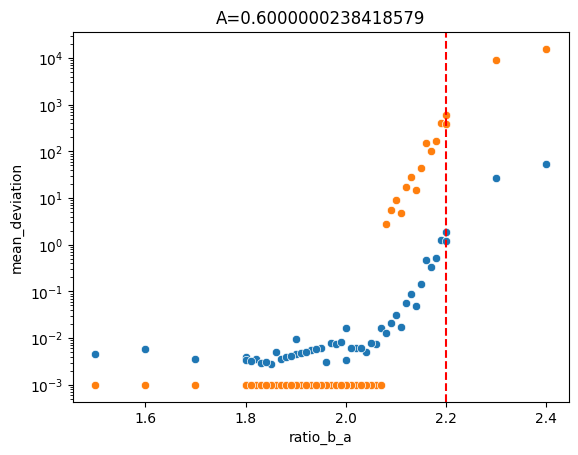

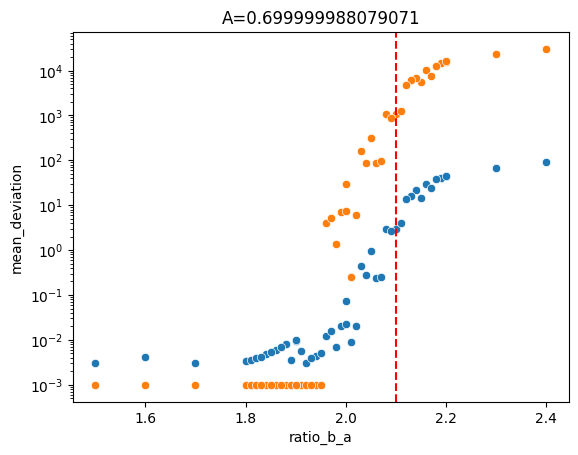

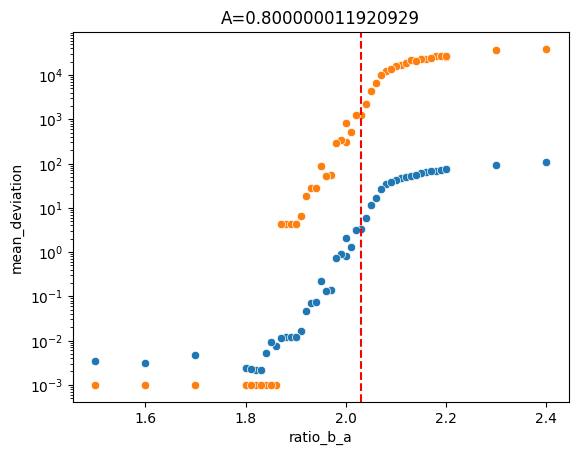

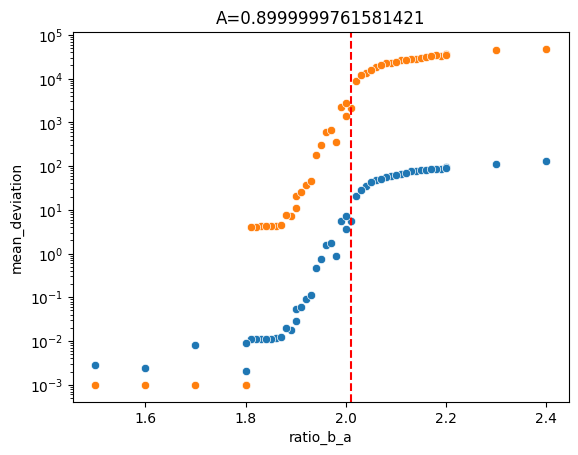

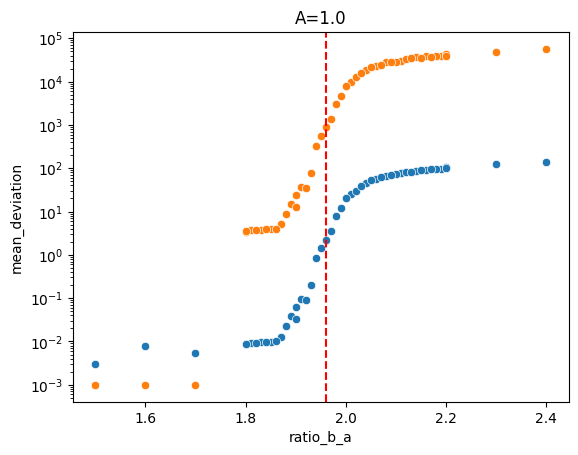

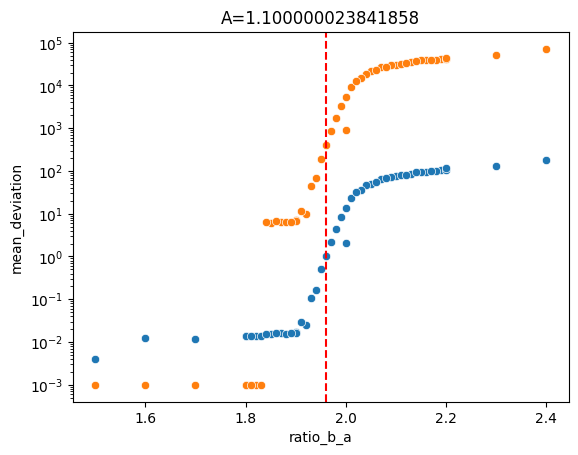

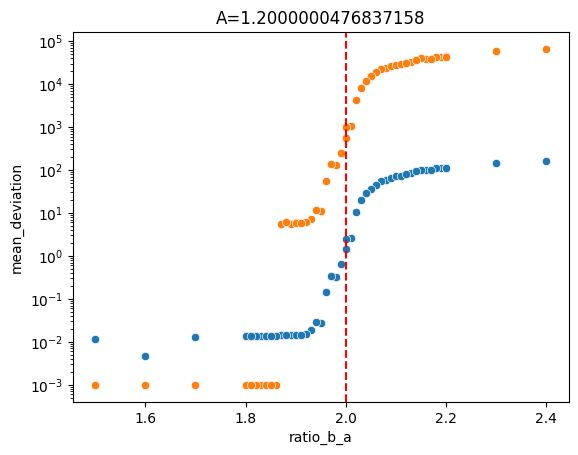

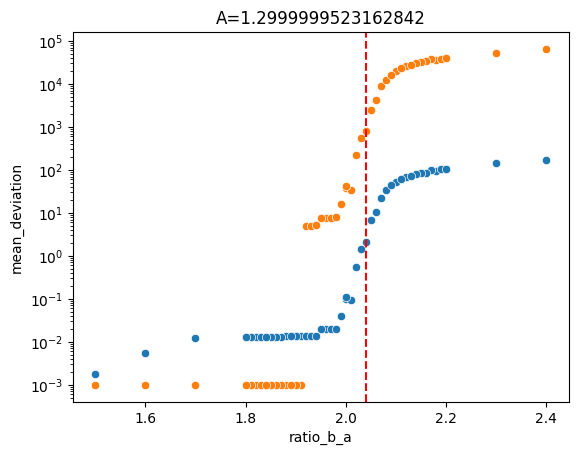

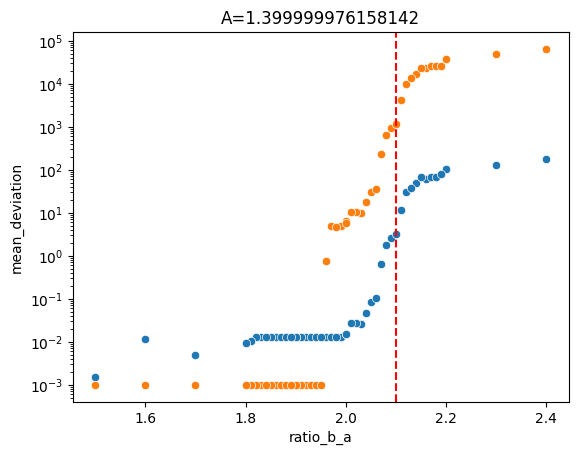

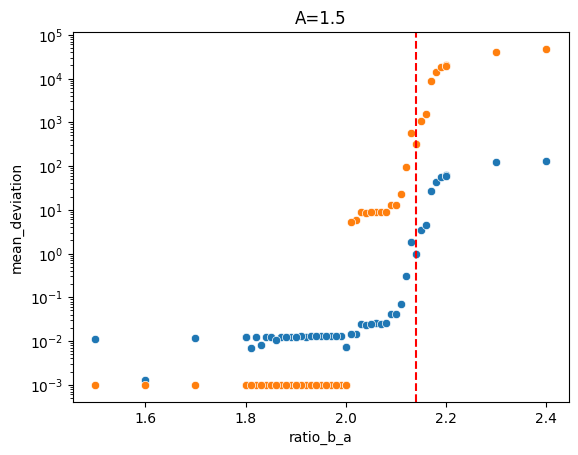

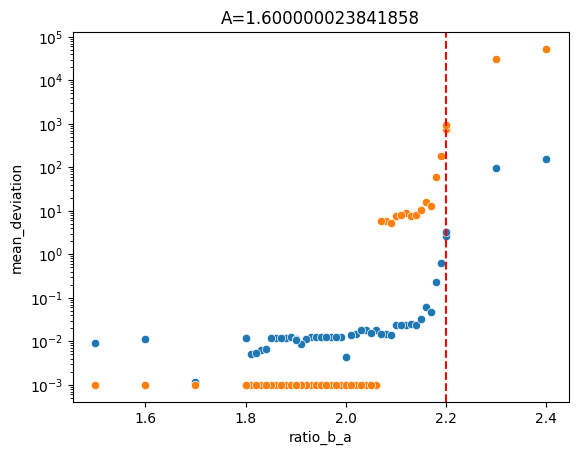

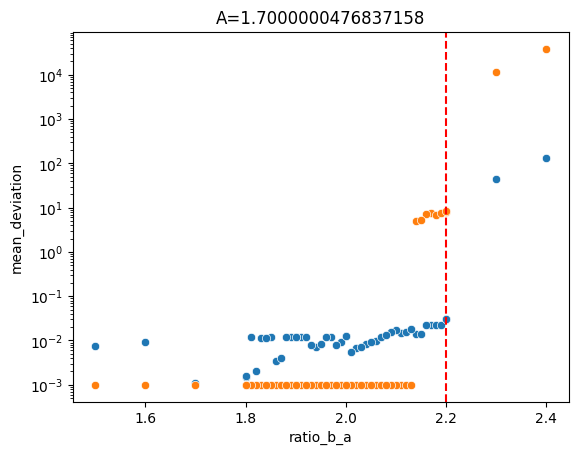

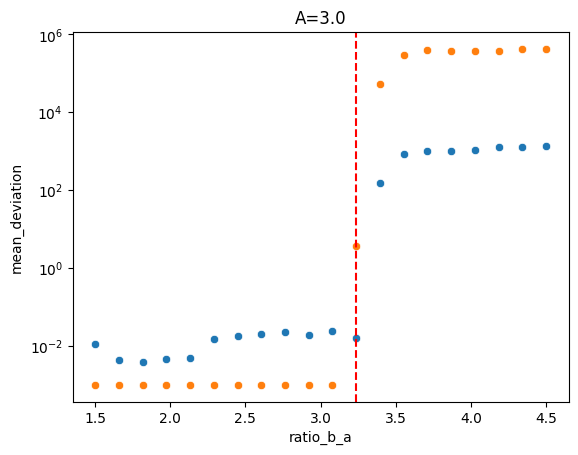

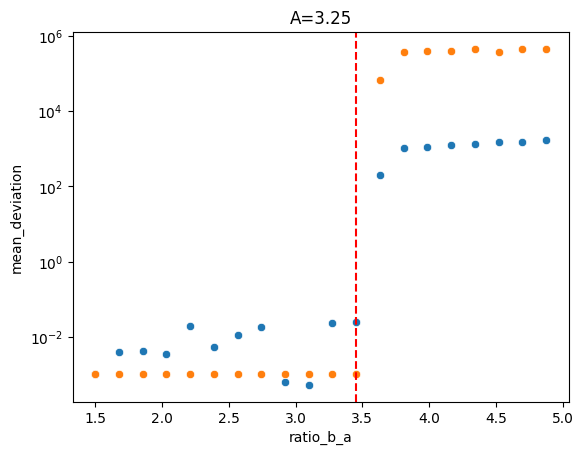

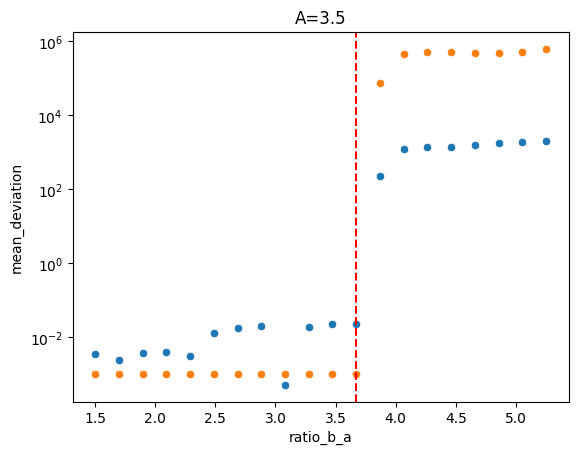

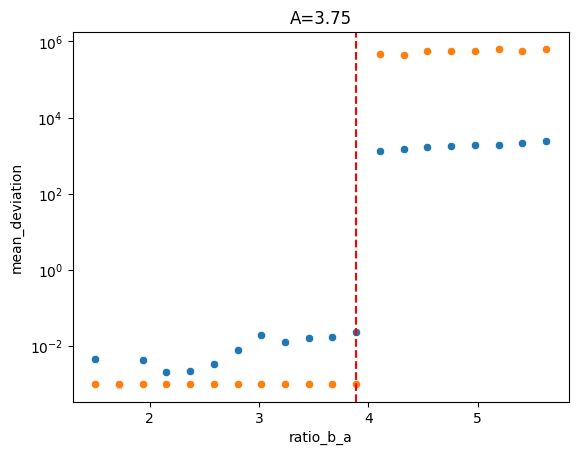

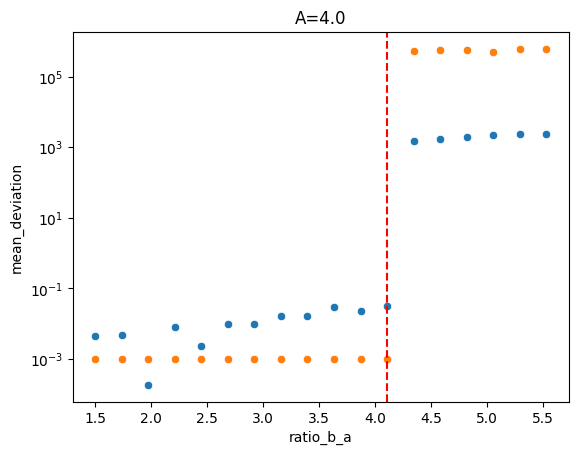

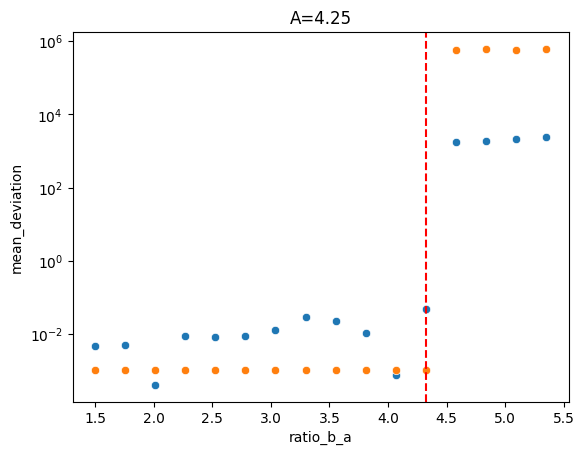

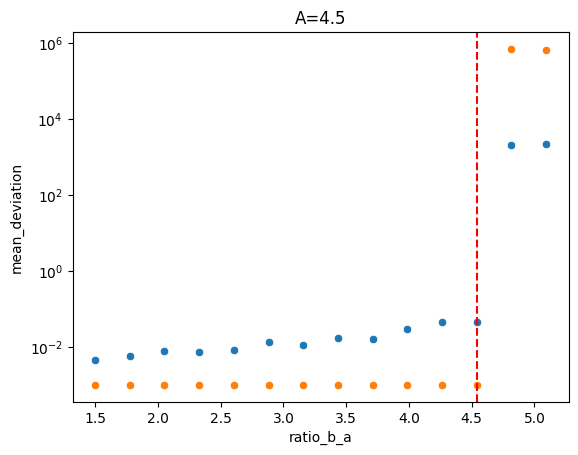

In [20]:
A_arr = []
pt_arr = []
metric = "mean_deviation"

for A, df_filt in df.groupby("A"):
    df1 = df_filt.sort_values("ratio_b_a")
    metric_data = df1[metric]
    idx = first_double_large_jump(metric_data)

    if idx != -1:
        # print(f"A = {A:.2f}, B/A = {df1.iloc[idx]['ratio_b_a']:.2f}")
        A_arr.append(A)
        ratio = df1.iloc[idx]["ratio_b_a"]
        pt_arr.append(ratio)
        plt.axvline(x=ratio, color="r", linestyle="--")
        # plt.axvline(x=ratio - 0.1, color="g", linestyle="-.")
        # plt.axvline(x=ratio + 0.1, color="g", linestyle="-.")
        plt.yscale("log")
        df_filt["mean_dt"] += 1e-3
        sns.scatterplot(data=df_filt, x="ratio_b_a", y=metric)
        sns.scatterplot(data=df_filt, x="ratio_b_a", y="mean_dt")
        plt.title(f"A={A}")
        plt.show()

plt.close("all")


[ 0.02814013 -0.35001042  1.60003947 -2.34595609  3.0677753 ]


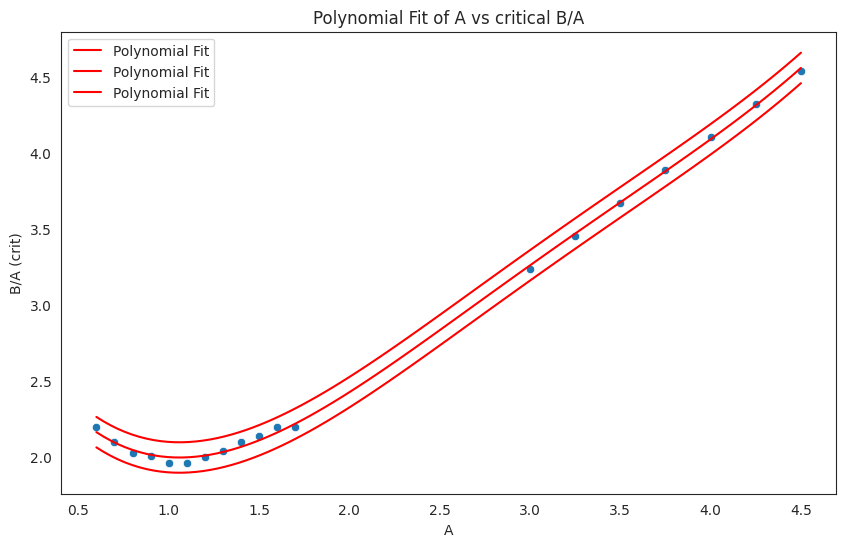

In [15]:
coefficients = np.polyfit(A_arr, pt_arr, deg=4)
polynomial = np.poly1d(coefficients)
print(coefficients)

x_vals = np.linspace(min(A_arr), max(A_arr), 100)
y_vals = polynomial(x_vals)

sns.set_style("white")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=A_arr, y=pt_arr)
sns.lineplot(x=x_vals, y=y_vals, label='Polynomial Fit', color='red')
sns.lineplot(x=x_vals, y=y_vals+0.1, label='Polynomial Fit', color='red')
sns.lineplot(x=x_vals, y=y_vals-0.1, label='Polynomial Fit', color='red')
plt.xlabel('A')
plt.ylabel('B/A (crit)')
plt.title('Polynomial Fit of A vs critical B/A')
plt.legend()
plt.show()

In [10]:
# Old code for determining the parameters of the run
df_new = pd.DataFrame(columns=["A", "B", "Du", "Dv"])

A_all = np.arange(0.5, 2.5, 0.1)
A_around_min = np.arange(1.0, 1.2, 0.01)
A_values = np.concatenate((A_all, A_around_min))
A_values = np.unique(A_values)
A_values = np.sort(A_values)
for A in A_values:
    ratio_b_a_center = polynomial(A)
    ratio_b_a_fine = np.linspace(ratio_b_a_center - 0.1, ratio_b_a_center + 0.1, 50)
    ratio_b_a_coarse = np.linspace(ratio_b_a_center - 0.5, ratio_b_a_center + 0.5, 40)

    ratio_b_a_values = np.concatenate((ratio_b_a_fine, ratio_b_a_coarse))
    ratio_b_a_values = np.unique(ratio_b_a_values)

    for ratio_b_a in ratio_b_a_values:
        df_new.loc[len(df_new)] = [A, ratio_b_a * A, 2.0, 22.0]

df_new.to_csv("../data/pt.csv")